##### Import the libraries

In [1]:
import os
import json
import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.ops import box_iou
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_recall_fscore_support
import rich
from segmentation_models_pytorch import Unet
from torchvision.transforms.functional import pad

#### load u_net

In [2]:
# Initialize U-Net model
model = Unet(encoder_name="resnet34",        # Choose encoder architecture
             encoder_weights="imagenet",    # Use pre-trained weights
             in_channels=3,                 # Input channels (RGB)
             classes=1)                     # Output channels (binary segmentation)

In [3]:
# Define the path to load the model
load_path = "unet_checkpoint.pth"

# Load the checkpoint
checkpoint = torch.load(load_path)

# Load the model state dictionary
model.load_state_dict(checkpoint['model_state_dict'])

# Load the optimizer state dictionary
#  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Retrieve the last completed epoch
start_epoch = checkpoint['epoch']

print(f"Model loaded from {load_path}, starting from epoch {start_epoch}")

Model loaded from unet_checkpoint.pth, starting from epoch 5


##### calculate the predicted area

In [4]:
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    
    # Compute the new dimensions divisible by 32
    original_width, original_height = image.size
    new_width = (original_width + 31) // 32 * 32
    new_height = (original_height + 31) // 32 * 32
    padding_left = (new_width - original_width) // 2
    padding_top = (new_height - original_height) // 2
    padding_right = new_width - original_width - padding_left
    padding_bottom = new_height - original_height - padding_top

    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to tensor
    ])
    image_tensor = transform(image)
    
    # Pad the image
    image_tensor = pad(image_tensor, (padding_left, padding_top, padding_right, padding_bottom))
    
    return image_tensor


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the path to your image
file_name = "rectified_facade_DENW11AL0000h3Gt.jpg"
image_path = os.path.join("Evaluation_subset", file_name)

# Load and preprocess the image
input_image = load_image(image_path).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Run the model
model.eval()
with torch.no_grad():
    output = model(input_image)  # U-Net output does not use ['out']

# Post-process the output to binary segmentation map
output = torch.sigmoid(output).squeeze().cpu().numpy()  # Apply sigmoid activation and remove batch dim

# Remove padding to return to original dimensions
original_height, original_width = Image.open(image_path).size
output_cropped = output[:original_height, :original_width]

# Apply a threshold to obtain binary mask (window vs non-window)
threshold = 0.5
binary_mask = (output_cropped > threshold).astype(float)

# Calculate the total area of predicted windows
windows_area_p = binary_mask.sum()  # Count pixels in the mask

# Print the total windows area
rich.print(f"Total predicted windows area for '{file_name}': {windows_area_p} pixels²")


Total predicted windows area for 'rectified_facade_DENW11AL0000h3Gt.jpg': 5437.0 pixels²

##### ground truth area

In [6]:
# Load the JSON file
file_path = os.path.join("Evaluation_subset", "labels_facade_dataset_2024-06-09-08-43-50.json")
with open(file_path, 'r') as f:
    data = json.load(f)

image_id = next(item["id"] for item in data["images"] if item["file_name"] == file_name)

# Step 2: Filter annotations for the image_id and category "window" (category_id = 1)
window_annotations = [
    annotation for annotation in data["annotations"]
    if annotation["image_id"] == image_id and annotation["category_id"] == 1
]

# Step 3: Calculate total area and count
windows_area_gt = sum(ann["area"] for ann in window_annotations)
num_windows = len(window_annotations)

# rich.print(f"Number of windows: {num_windows}")
rich.print(f"Total window area for '{file_name}': {windows_area_gt} pixels²")


Total window area for 'rectified_facade_DENW11AL0000h3Gt.jpg': 21784.693692249522 pixels²

##### image area

In [7]:
# Step 1: Find the image details for the given file name
image_details = next(item for item in data["images"] if item["file_name"] == file_name)

# Extract width and height
image_width = image_details["width"]
image_height = image_details["height"]

# Calculate the image area
image_area = image_width * image_height

# rich.print(f"Image dimensions for '{file_name}': {image_width}x{image_height}")
rich.print(f"Total image area for '{file_name}': {image_area} pixels²")

Total image area for 'rectified_facade_DENW11AL0000h3Gt.jpg': 91664 pixels²

##### WWR

In [8]:
# Calculate ground truth WWR
wwr_gt = windows_area_gt / image_area if image_area > 0 else 0

rich.print(f"Window-to-Wall Ratio (ground truth) (WWR) for '{file_name}': {wwr_gt:.4f}")

# Calculate predicted WWR
wwr_P = windows_area_p / image_area if image_area > 0 else 0

rich.print(f"Window-to-Wall Ratio (predcited) (WWR) for '{file_name}': {wwr_P:.4f}")

# Calculate the absolute difference
wwr_difference = abs(wwr_gt - wwr_P)

# Optionally, calculate percentage difference
wwr_percentage_diff = (wwr_difference / wwr_gt * 100) if wwr_gt > 0 else 0

# Print the results
# rich.print(f"[bold]Difference between ground truth and predicted WWR:[/bold] {wwr_difference:.4f}")
rich.print(f"[bold]Percentage difference:[/bold] {wwr_percentage_diff:.2f}%")

Window-to-Wall Ratio (ground truth) (WWR) for 'rectified_facade_DENW11AL0000h3Gt.jpg': 0.2377

Window-to-Wall Ratio (predcited) (WWR) for 'rectified_facade_DENW11AL0000h3Gt.jpg': 0.0593

Percentage difference: 75.04%

##### Visualizing the results on the Evalution subset

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

def visualize_segmentation(prediction_mask, image_tensor, threshold=0.5, class_names=None):
    """
    Visualizes the segmentation predictions on an image.

    Args:
        prediction_mask (np.array): Binary segmentation mask (H, W).
        image_tensor (Tensor): Original image tensor.
        threshold (float): Threshold applied to prediction probabilities.
        class_names (list): Optional list of class names, where index corresponds to class label.
    """
    # Convert the tensor to a PIL image for visualization
    img = transforms.ToPILImage()(image_tensor.cpu())

    # Create a figure
    plt.figure(figsize=(10, 10))

    # Show the original image
    plt.imshow(img, alpha=1.0)

    # Overlay the segmentation mask
    masked_image = np.ma.masked_where(prediction_mask == 0, prediction_mask)
    plt.imshow(masked_image, cmap='Reds', alpha=0.5, vmin=0, vmax=1)

    '''
    # Add a colorbar
    if class_names:
        cbar = plt.colorbar(ticks=range(len(class_names)))
        cbar.ax.set_yticklabels(class_names)
        '''

    plt.axis('off')
    # plt.title("Predicted Segmentation")
    plt.show()


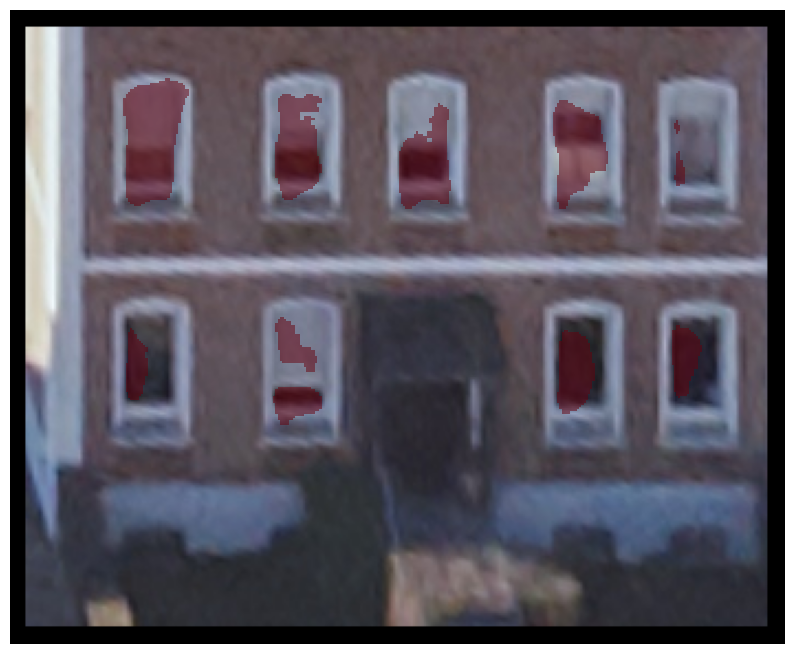

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the correct device
model = model.to(device)
# Define the path to your image
image_path = os.path.join("Evaluation_subset", "rectified_facade_DENW11AL0000h3Gt.jpg")

# Load the image
input_image = load_image(image_path).unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)

# Run the model on the image
model.eval()
# Process the model output
with torch.no_grad():
    output = model(input_image)  # U-Net output does not use ['out']

# Apply sigmoid to get probabilities
segmentation_map = torch.sigmoid(output).squeeze().cpu().numpy()

# Apply threshold to generate a binary mask
threshold = 0.5
binary_mask = (segmentation_map > threshold).astype(np.uint8)

# Visualize the segmentation predictions
class_names = ["background", "window"]  # Adjust based on your classes
visualize_segmentation(binary_mask, input_image[0], threshold=threshold, class_names=class_names)
